In [19]:
import pandas as pd
from tqdm import tqdm
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import itertools


%matplotlib inline 

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [31]:
dept_df = pd.read_csv('dept_lookup.txt', sep = '|')

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020,2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')



def prophet_model(df,c,ncpoints,prior_scale,w,y,h_scale_prior,dep_name):
    df['DAY_ID'] = pd.to_datetime(df['DAY_ID'])
    df['ACTUAL_SALES']=df.ACTUAL_SALES.mask(df.ACTUAL_SALES <= 0,0.1)
    df['ACTUAL_SALES_orig'] = df['ACTUAL_SALES'] 
    df['ACTUAL_SALES'] = np.log(df['ACTUAL_SALES'])
    df=df[['DAY_ID','ACTUAL_SALES','ACTUAL_SALES_orig']].rename(columns={'DAY_ID': 'ds', 'ACTUAL_SALES': 'y','ACTUAL_SALES_orig':'y_orig'})
    m = Prophet(holidays=holiday,changepoints=c,n_changepoints=ncpoints,changepoint_prior_scale=prior_scale,weekly_seasonality=w,yearly_seasonality=y,holidays_prior_scale=h_scale_prior)
    m.add_country_holidays(country_name='US')
    m.fit(df) 
    future = m.make_future_dataframe(periods=365, freq = 'D') 
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    forecast_data_orig = forecast 
    forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
    forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
    forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])
    df['y_log']=df['y']
    df['y']=df['y_orig']
    df.set_index('ds', inplace=True)
    forecast.set_index('ds', inplace=True)
    viz_df = df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    metric_df=viz_df.copy()
    metric_df.dropna(inplace=True)
    r2_score(metric_df.y, metric_df.yhat)
    mean_squared_error(metric_df.y, metric_df.yhat)
    mean_absolute_error(metric_df.y, metric_df.yhat)
    viz_df[['y', 'yhat']].plot()
    stuff_in_string = "department %s prediction." % (dep_name)
    plt.title(stuff_in_string)
    plt.xlabel('Date')
    plt.ylabel('Actual_sales(1e6)')
    plt.show()
    return(viz_df[['y', 'yhat']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


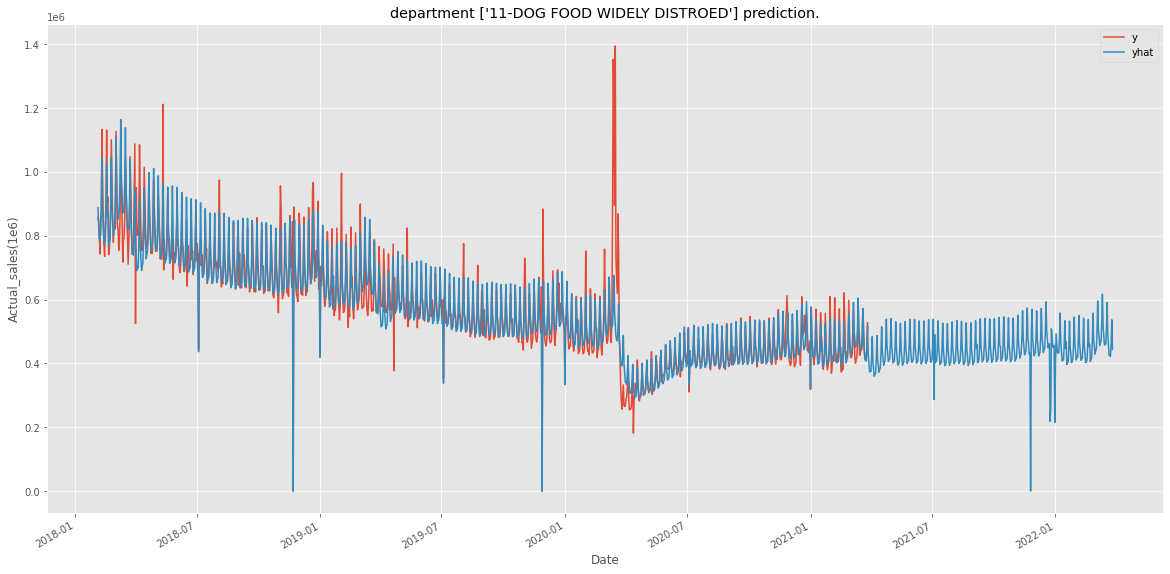

In [32]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
dept_id = 11
dep_name = dept_df.loc[dept_df.DEPARTMENT_ID==11,'DEPARTMENT'].values
store_spe = prophet_model(all[dept_id],None,25,0.05,'auto','auto',20,dep_name)


In [14]:
alld=pd.read_csv('~/git/petco-challenge/daily_dep_sale_bm.csv')

In [15]:
alld['DEPARTMENT_ID'].unique()

array([ 0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       30, 31, 32, 33, 34, 36, 40, 42, 44, 45, 47, 48, 50, 51, 52, 53, 54,
       55, 58, 60, 61, 62, 63, 64, 65, 66, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 92, 97, 98, 99,  3,
       96, 93, 68, 94, 56, 67, 69, 35, 57,  1, 46, 59, 26,  4])

In [16]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))

In [62]:
from sklearn.model_selection import ParameterGrid
params_grid = {'changepoint_prior_scale':[0.1,0.05,0.01],
              'holidays_prior_scale':[5,10,20],
              'n_changepoints' : [25,100,150]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 27


In [39]:
Dep_forecast=pd.DataFrame()
dep=[]
sales_predict=[]
r2=[]
mse=[]
mae=[]

for i in range(10,11):
    all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
    df=all[alld['DEPARTMENT_ID'].unique()[i]]
    df['DAY_ID'] = pd.to_datetime(df['DAY_ID'])
    df['ACTUAL_SALES']=df.ACTUAL_SALES.mask(df.ACTUAL_SALES <= 0,0.1)
    df['ACTUAL_SALES_orig'] = df['ACTUAL_SALES'] 
    df['ACTUAL_SALES'] = np.log(df['ACTUAL_SALES'])
    df=df[['DAY_ID','ACTUAL_SALES','ACTUAL_SALES_orig']].rename(columns={'DAY_ID': 'ds', 'ACTUAL_SALES': 'y','ACTUAL_SALES_orig':'y_orig'})
    strt='2018-02-04'
    end='2021-03-27'
    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    for p in grid:
        test = pd.DataFrame()
        random.seed(0)
        train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                             holidays_prior_scale = p['holidays_prior_scale'],
                             n_changepoints = p['n_changepoints'],
                             seasonality_mode = p['seasonality_mode'],
                             weekly_seasonality= 'auto',
                             daily_seasonality = 'auto',
                             yearly_seasonality = 'auto',
                             holidays=holiday, 
                             interval_width=0.95)
        train_model.add_country_holidays(country_name='US')
        train_model.fit(df)
        future = train_model.make_future_dataframe(periods=365, freq='D')
        forecast = train_model.predict(future)
        test=forecast[['ds','yhat']]
        Actual = df[(df['ds']>strt) & (df['ds']<=end)]
        MAPE = mean_absolute_percentage_error(Actual['y'],abs(test[(test['ds']>strt) & (test['ds']<=end)]['yhat']))
        model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
    parameters = model_parameters.sort_values(by=['MAPE'])
    parameters = parameters.reset_index(drop=True)
    c=parameters['Parameters'][0]
    final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= c['changepoint_prior_scale'],
                      holidays_prior_scale = c['holidays_prior_scale'],
                      n_changepoints = c['n_changepoints'],
                      seasonality_mode = c['seasonality_mode'],
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
    final_model.add_country_holidays(country_name='US')
    final_model.fit(df)
    future = final_model.make_future_dataframe(periods=365, freq = 'D') 
    forecast = final_model.predict(future)
    forecast_data_orig = forecast 
    forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
    forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
    forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])
    df['y_log']=df['y']
    df['y']=df['y_orig']
    df.set_index('ds', inplace=True)
    forecast.set_index('ds', inplace=True)
    viz_df = df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    metric_df=viz_df.copy()
    metric_df.dropna(inplace=True)
    r2.append(r2_score(metric_df.y, metric_df.yhat))
    mse.append(mean_squared_error(metric_df.y, metric_df.yhat))
    mae.append(mean_absolute_error(metric_df.y, metric_df.yhat))
    sales_predict.append(viz_df[viz_df.index>end]['yhat'].sum())
    dep=i
    
Dep_forecast['dep']=dept_df.loc[dept_df.DEPARTMENT_ID==dep,'DEPARTMENT']
Dep_forecast['sales_predict']=sales_predict
Dep_forecast['r2']=r2
Dep_forecast['mse']=mse
Dep_forecast['mae']=mae
Dep_forecast

,dep,sales_predict,r2,mse,mae
0,NaN,4.641311e+08,0.815264,1.170476e+09,18728.999731


# USE THIS!

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

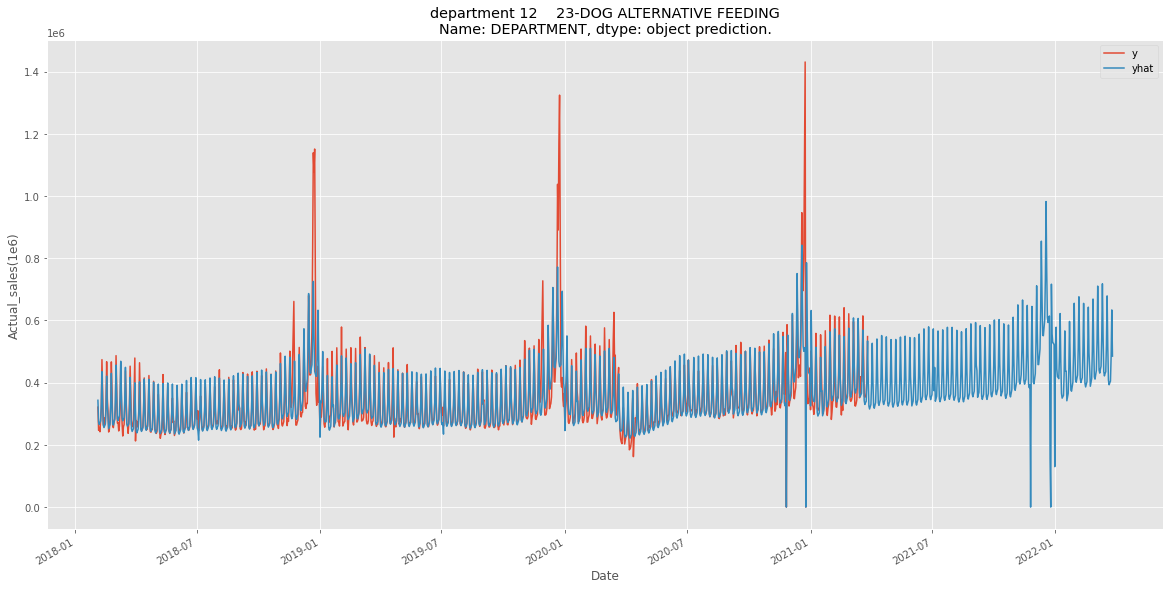

,dep,sales_predict,r2,mse,mae
12,23-DOG ALTERNATIVE FEEDING,1.590516e+08,0.651485,4.724226e+09,26770.270323


In [63]:
Dep_forecast=pd.DataFrame()
dep=[]
sales_predict=[]
r2=[]
mse=[]
mae=[]

for i in range(23,24):
    all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
    df=all[alld['DEPARTMENT_ID'].unique()[i]]
    df['DAY_ID'] = pd.to_datetime(df['DAY_ID'])
    df['ACTUAL_SALES']=df.ACTUAL_SALES.mask(df.ACTUAL_SALES <= 0,0.1)
    df['ACTUAL_SALES_orig'] = df['ACTUAL_SALES'] 
    df['ACTUAL_SALES'] = np.log(df['ACTUAL_SALES'])
    df=df[['DAY_ID','ACTUAL_SALES','ACTUAL_SALES_orig']].rename(columns={'DAY_ID': 'ds', 'ACTUAL_SALES': 'y','ACTUAL_SALES_orig':'y_orig'})
    strt='2018-02-04'
    end='2021-03-27'
    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    for p in grid:
        test = pd.DataFrame()
        random.seed(0)
        train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                             holidays_prior_scale = p['holidays_prior_scale'],
                             n_changepoints = p['n_changepoints'],
                             seasonality_mode = 'additive',
                             weekly_seasonality= 'auto',
                             daily_seasonality = 'auto',
                             yearly_seasonality = 'auto',
                             holidays=holiday, 
                             interval_width=0.8)
        train_model.add_country_holidays(country_name='US')
        train_model.fit(df)
        future = train_model.make_future_dataframe(periods=365, freq='D')
        forecast = train_model.predict(future)
        test=forecast[['ds','yhat']]
        Actual = df[(df['ds']>strt) & (df['ds']<=end)]
        MAPE = mean_absolute_percentage_error(Actual['y'],abs(test[(test['ds']>strt) & (test['ds']<=end)]['yhat']))
        model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
    parameters = model_parameters.sort_values(by=['MAPE'])
    parameters = parameters.reset_index(drop=True)
    c=parameters['Parameters'][0]
    final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= c['changepoint_prior_scale'],
                      holidays_prior_scale = c['holidays_prior_scale'],
                      n_changepoints = c['n_changepoints'],
                      seasonality_mode = 'additive',
                      weekly_seasonality='auto',
                      daily_seasonality = 'auto',
                      yearly_seasonality = 'auto',
                      interval_width=0.8)
    final_model.add_country_holidays(country_name='US')
    final_model.fit(df)
    future = final_model.make_future_dataframe(periods=365, freq = 'D') 
    forecast = final_model.predict(future)
    forecast_data_orig = forecast 
    forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
    forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
    forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])
    df['y_log']=df['y']
    df['y']=df['y_orig']
    df.set_index('ds', inplace=True)
    forecast.set_index('ds', inplace=True)
    viz_df = df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    metric_df=viz_df.copy()
    metric_df.dropna(inplace=True)
    r2.append(r2_score(metric_df.y, metric_df.yhat))
    mse.append(mean_squared_error(metric_df.y, metric_df.yhat))
    mae.append(mean_absolute_error(metric_df.y, metric_df.yhat))
    sales_predict.append(viz_df[viz_df.index>end]['yhat'].sum())
    dep=i
    dep_name = dept_df.loc[dept_df.DEPARTMENT_ID==dep,'DEPARTMENT']
    viz_df[['y', 'yhat']].plot()
    viz_df.to_csv()
    stuff_in_string = "department %s prediction." % (dep_name)
    plt.title(stuff_in_string)
    plt.xlabel('Date')
    plt.ylabel('Actual_sales(1e6)')
    plt.show()
    downloadcsv = "department %s prediction.csv" % (dep_name)
    viz_df.to_csv(downloadcsv)

Dep_forecast['dep']=dept_df.loc[dept_df.DEPARTMENT_ID==dep,'DEPARTMENT']
Dep_forecast['sales_predict']=sales_predict
Dep_forecast['r2']=r2
Dep_forecast['mse']=mse
Dep_forecast['mae']=mae
Dep_forecast

In [64]:
c

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 20,
 'n_changepoints': 150}

In [49]:
all[10]

,Unnamed: 0,DAY_ID,DEPARTMENT_ID,GROSS_SALES,PROMO_DISCOUNT,CLEARANCE_DISCOUNT,COUPON_DISCOUNT,MISCELLANOUS_DISCOUNT,ACTUAL_SALES,UNITS_SOLD,INITIAL_MARGIN,AVG_CUSTOMER_SHOP_INTERVAL_IN_DAYS
1,1,2018-02-04,10,707078.90,67284.33,4820.85,12604.90,3865.62,618565.12,48193,164039.3326,163.787918
69,69,2018-02-05,10,715343.76,66033.04,3368.99,12325.88,5252.27,628548.82,51993,170391.0969,156.820461
135,135,2018-02-06,10,692197.32,64149.21,4829.40,11234.73,4809.94,607262.93,49895,163420.3387,158.563955
202,202,2018-02-07,10,627209.30,58977.71,2817.70,10714.94,4299.44,550497.46,43959,149576.3494,154.933523
268,268,2018-02-08,10,706328.97,65987.98,3413.76,10432.97,4524.38,622068.98,50790,170192.6200,159.123477
...,...,...,...,...,...,...,...,...,...,...,...,...
77784,77784,2021-03-23,10,1001553.83,64926.52,14503.15,10906.14,6329.51,906922.53,53959,283538.2901,267.135169
77853,77853,2021-03-24,10,995730.13,65033.07,12202.75,11849.33,4940.25,903907.75,54239,284046.6770,261.731755
77923,77923,2021-03-25,10,1011778.39,65888.97,13366.40,11681.14,5562.39,917676.46,54273,286896.5758,256.734882
77996,77996,2021-03-26,10,1049086.96,67719.33,13777.85,13637.23,6527.89,949796.78,57367,296286.4890,279.311699


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

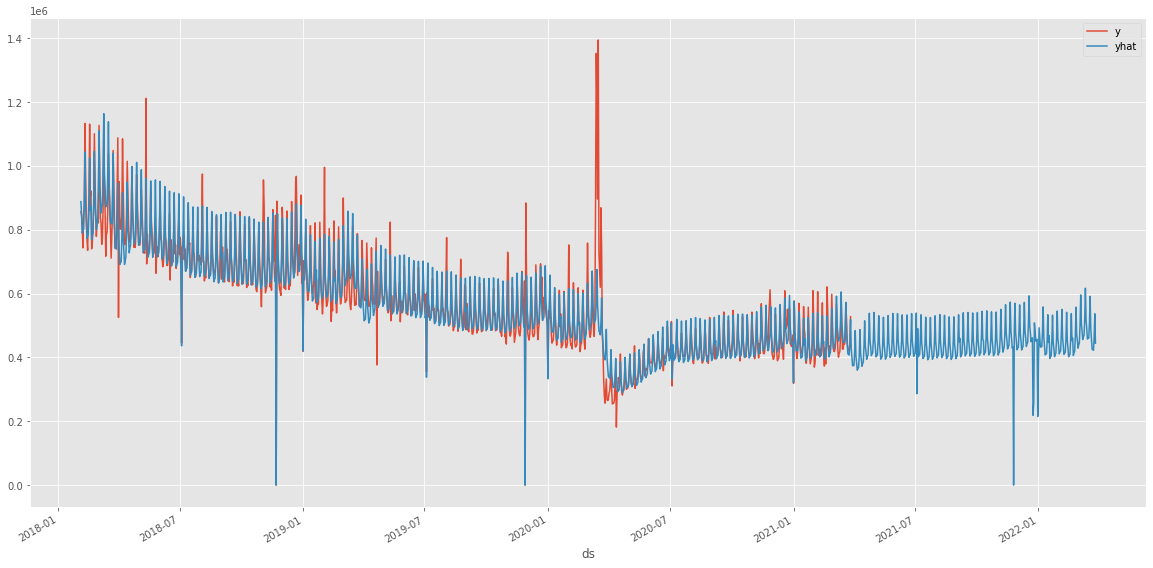

In [36]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[11],None,25,0.05,'auto','auto',20)

In [49]:
c

{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 20,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

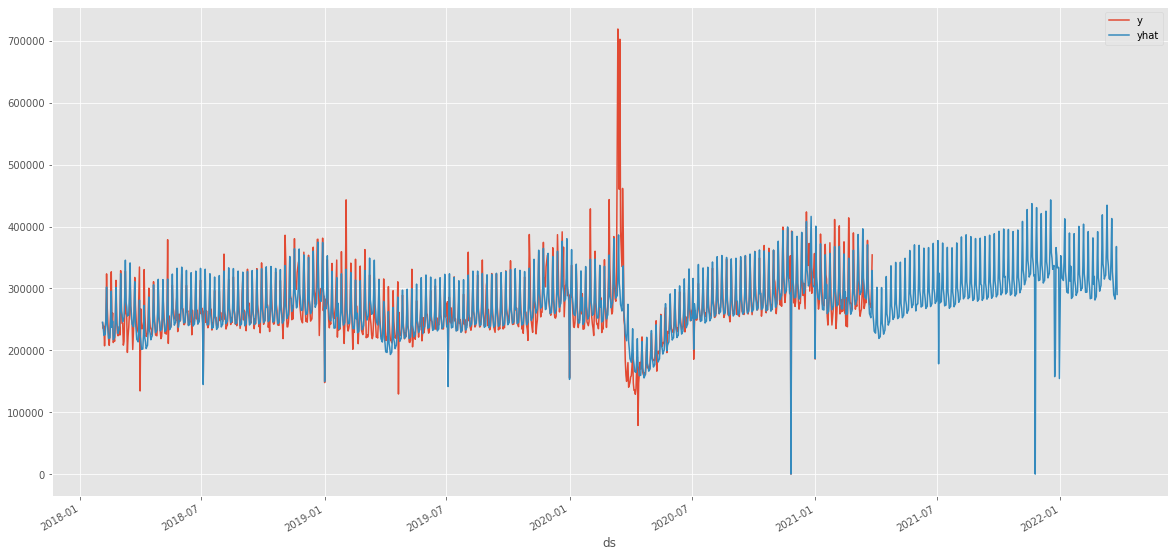

In [37]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[12],None,25,0.05,'auto','auto',20)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

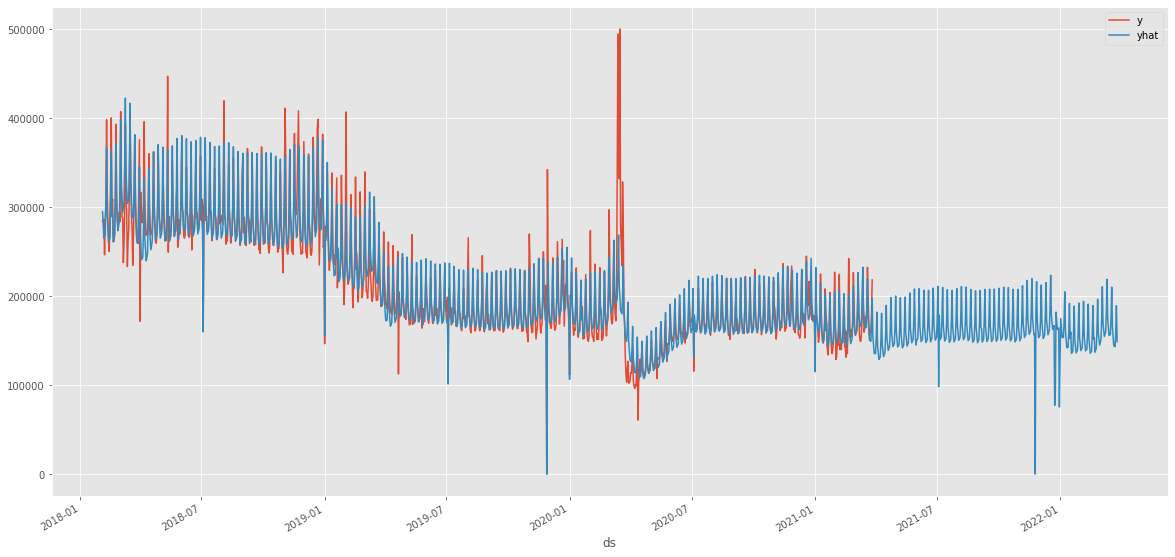

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

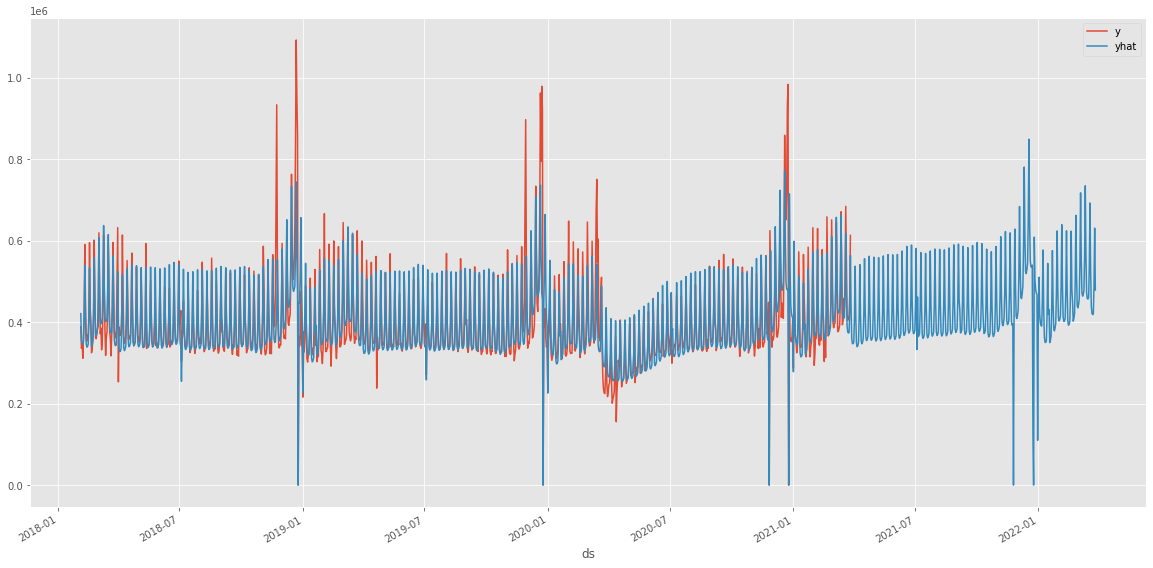

In [39]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[14],None,25,0.05,'auto','auto',20)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

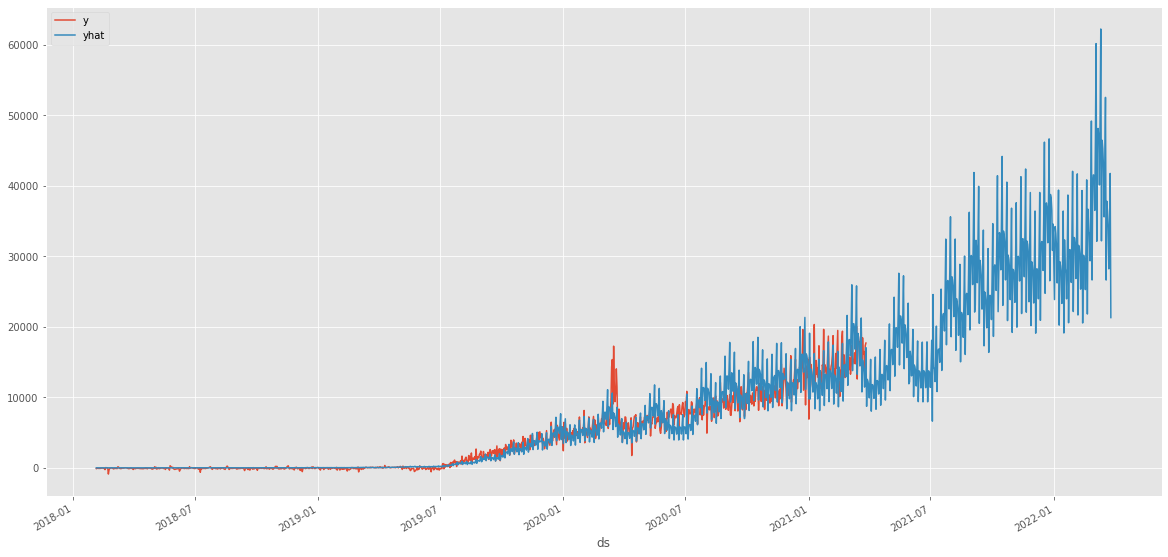

In [40]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[15],None,25,0.05,'auto','auto',20)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

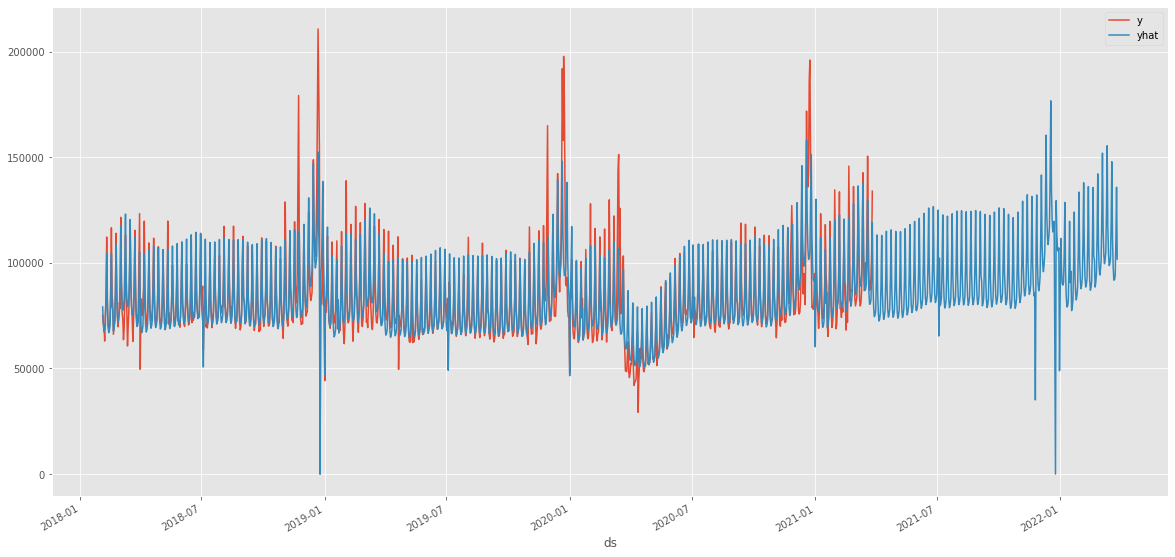

In [41]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[16],None,25,0.05,'auto','auto',20)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

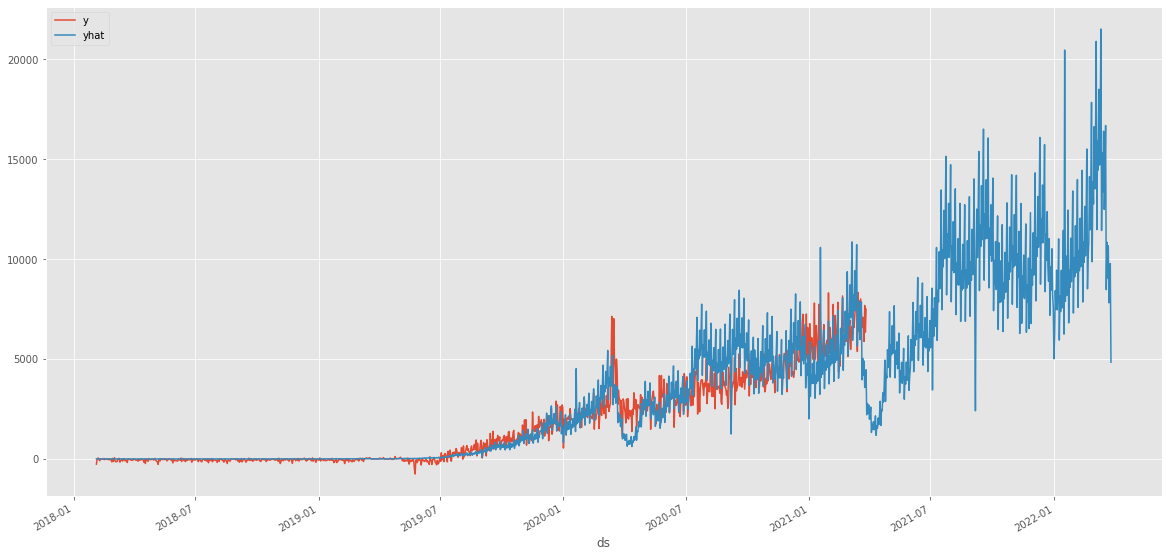

In [42]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[17],None,25,0.05,'auto','auto',20)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

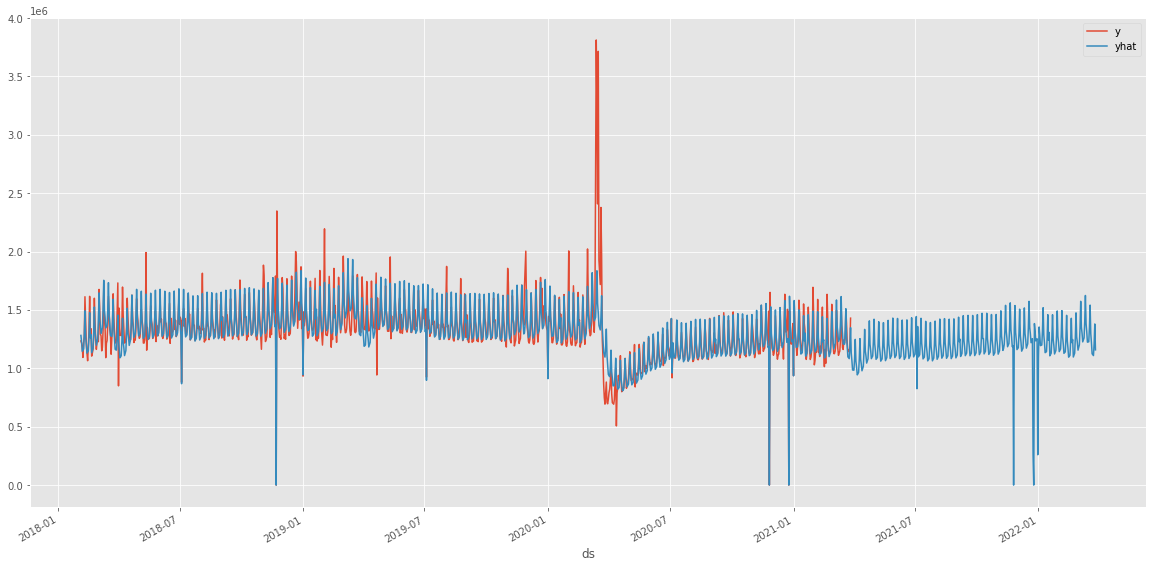

In [43]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[18],None,25,0.05,'auto','auto',20)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

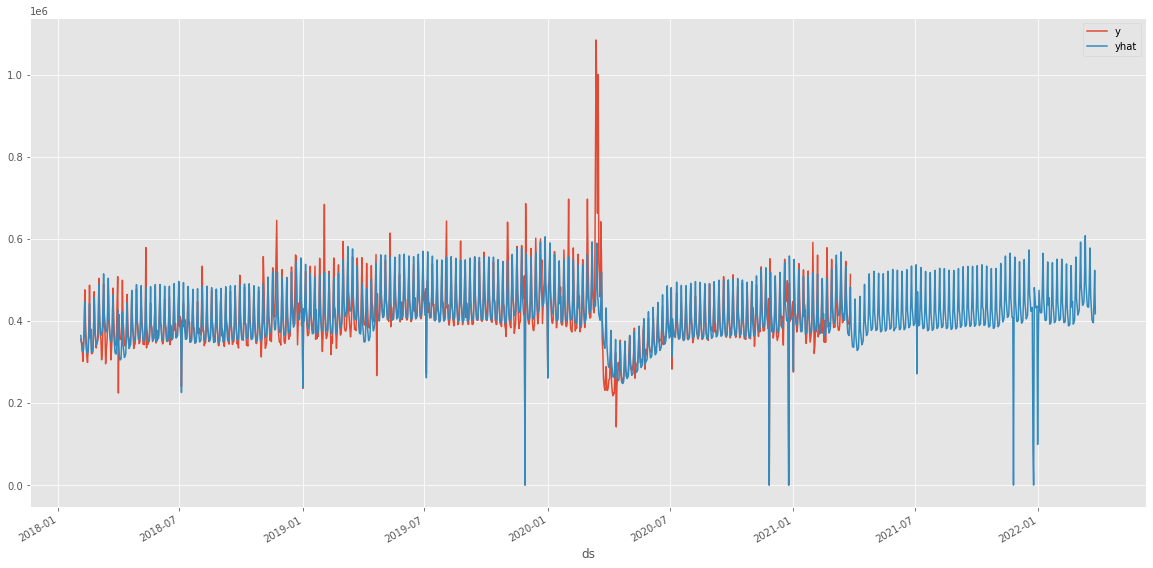

In [44]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[19],None,25,0.05,'auto','auto',20)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

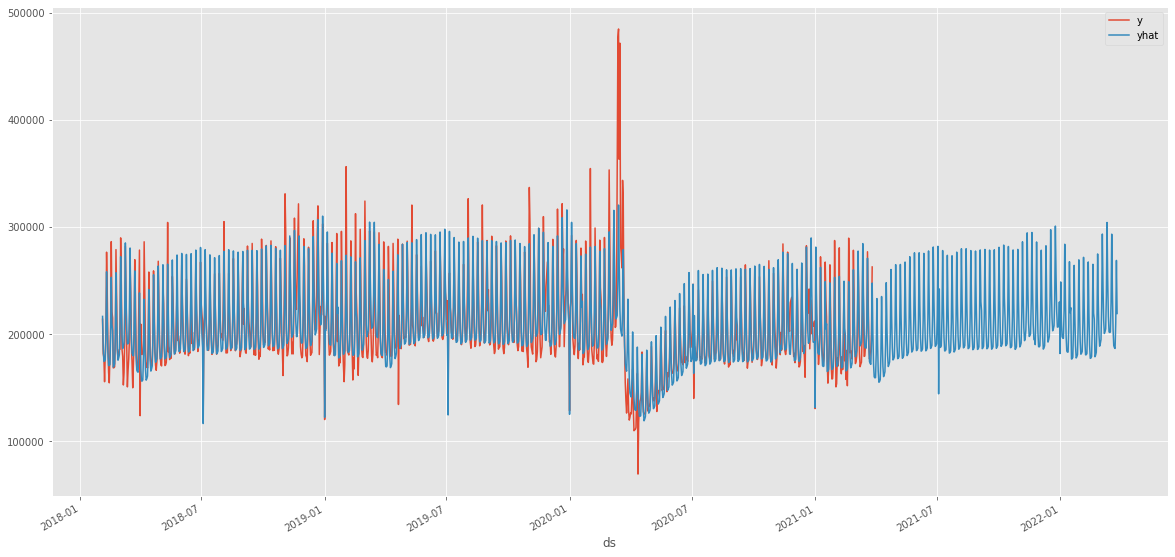

In [45]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[20],None,25,0.05,'auto','auto',20)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

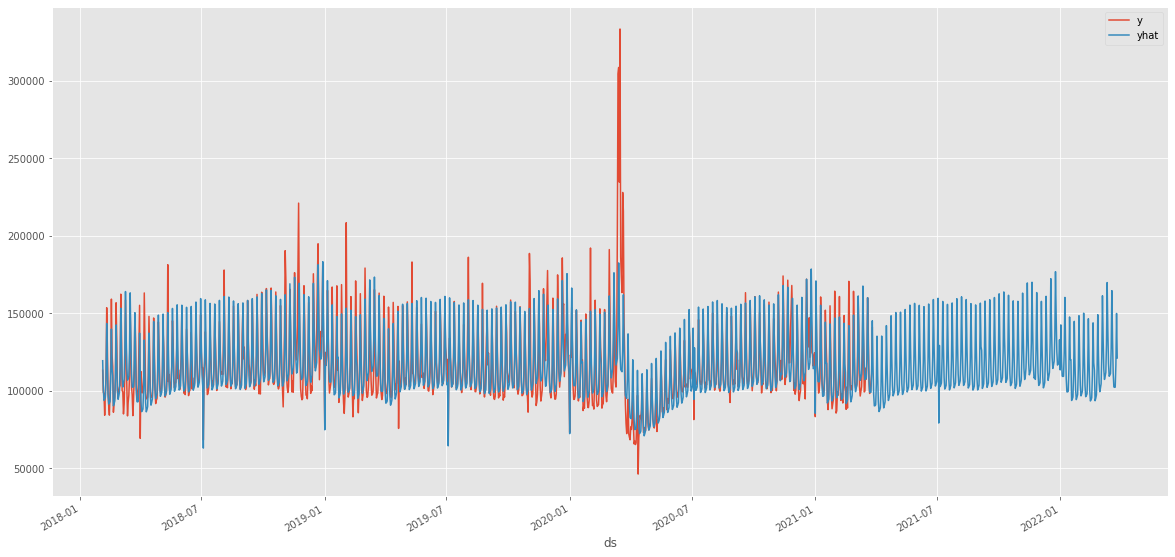

In [46]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[21],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[22],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)

In [ ]:
all=dict(tuple(alld.groupby(['DEPARTMENT_ID'])))
prophet_model(all[10],None,25,0.05,'auto','auto',20)